Clustering experiment #1
========================

Plan:
-----

 * Derive a vector for left and righthand alignment variance for each contiguous block of text in each article (newspaper has pages, which hold articles, which consist of blocks).
 * Create a k=8 kmeans clustering using data from all newspapers from 1745 to 1756.
 * Visualise the clustering
 * Given the set of found poems, see into which clusters the poems get assigned.
 * Report on the spread of these and if a cluster is found which just has poems, report on all of the references within that cluster.

In [1]:
%matplotlib inline

# Load this library to make the graphs interactive for smaller samples
#import mpld3
#mpld3.enable_notebook()

# Turns out, multiple interactive scattergraphs with 170,000+ points each is a bit too much for a browser
# Who knew?! 

In [2]:
# Get the dataset:
from clustering import create_cluster_dataset, NewspaperArchive
DBFILE = "1745_1756_no_drift.db"
n = NewspaperArchive()
ds = create_cluster_dataset(n, daterange = [1745, 1756], dbfile = DBFILE)


Loading from db cache '1745_1756_no_drift.db'
170339 vectors loaded.


What do these 'vectors' look like? What do the columns refer to?

In [3]:
data, transform, id_list = ds
print(data.toarray())

print(transform.get_feature_names())

[[  4.06902985e+00   4.36200000e+03  -6.78854839e+02 ...,   5.26129032e+01
    2.28537981e+00   0.00000000e+00]
 [  9.25095785e+00   4.82900000e+03  -9.04459016e+02 ...,   2.97377049e+01
    5.52700887e+00   0.00000000e+00]
 [  1.68010517e+00   3.83400000e+03  -8.20021739e+02 ...,   4.95434783e+01
    7.56499527e+02   0.00000000e+00]
 ..., 
 [  1.81267474e+00   5.83500000e+03  -9.39681159e+02 ...,   4.17246377e+01
    1.73811384e+02   0.00000000e+00]
 [  3.74772727e-01   3.29800000e+03  -7.68963636e+02 ...,   4.71454545e+01
    7.99259504e+01   0.00000000e+00]
 [  1.52893411e-04   2.38000000e+02   8.50000000e+01 ...,   1.69420000e+03
    2.85616000e+04   0.00000000e+00]]
['density', 'ltcount', 'redge_x2ave', 'x1_var1', 'x1_var2', 'x1ave_ledge', 'x2_var1', 'x2_var2']


Going from a vector back to the metadata reference:
---------------------------------------------------

By keeping an 'id_list', we can look up the identifier for any vector in the list from the database we've made for this clustering attemp. This lets us look up what the reference for that is, and where we can find it:

In [4]:
from clustering import ClusterDB
db = ClusterDB(DBFILE)
item = dict(db.vecidtoitem(id_list[-1]))
print(item)

from burney_data import BurneyDB
bdb = BurneyDB("burney.db")

titlemd = bdb.get_title_row(titleAbbreviation=item['newspaper'])
entry = bdb.get_entry_row(year=item['year'], month=item['month'], day=item['day'], title_id= titlemd['id'])
issue = bdb.get_issue_row(id=entry['issue_id'])

print(titlemd)
print(issue)
print(entry)

{'block_number': '7', 'year': '1746', 'day': '27', 'newspaper': 'B0477OLENCOJO', 'month': '09', 'page': '0004', 'vector_id': 223713, 'article': '006', 'id': 223713}
{'earliest_issue': None, 'titleContinuedBy': 'OLD ENGLAND OR THE BROADBOTTOM JOURNAL', 'datesOfPublication': '1743-1746', 'id': 405, 'titleContinues': '', 'typeOfPublication': 'NEWSPAPER', 'titleAbbreviation': 'B0477OLENCOJO', 'last_issue': None, 'title': 'OLD ENGLAND OR THE CONSTITUTIONAL JOURNAL', 'placeOfPublication': 'LONDON'}
{'volumeNumber': None, 'title_id': 405, 'id': 115004, 'pageCount': '4', 'ESTC': 'P1753', 'printedDate': 'SATURDAY SEPTEMBER 27 1746', 'normalisedDate': '1746-09-27', 'issueNumber': '178'}
{'number_of_articles': 6, 'title_id': 405, 'year': '1746', 'id': 115004, 'month': '09', 'filepath': '/cygdrive/w/APEX/B0477OLENCOJO/1746/09/27/service', 'issue_id': 115004, 'day': '27'}


In [5]:
import numpy as np
from matplotlib import pyplot as plt

# Mask off leaving just the left and right variance columns
npdata = data.toarray()
mask = np.ones((8), dtype=bool)
mask[[0,1,2,4,5,7]] = False

marray = npdata[:,mask]

x1 vs x2 varience?
------------------

What is the rough shape of this data? The varience of x1 and x2 are equivalent to the left and right alignment of the text varies in a given block of text.

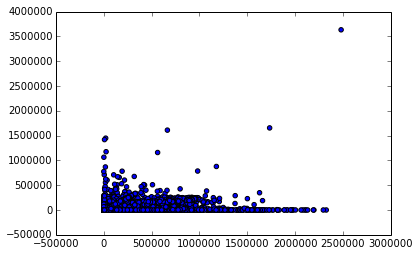

In [ ]:
plt.scatter(marray[:,0], marray[:,1])
plt.show()

Attempting K-Means
==================

What sort of clustering algorithm to employ is actually a good question. K-means can give fairly meaningless responses if the data is of a given sort. Generally, it can be useful but cannot be used blindly. 

Given the data above, it might be a good start however.

In [6]:
# Build the clustering and show the individual clusters as best we can:
from sklearn.cluster import KMeans

estimator = KMeans(n_clusters=8)

clusters = estimator.fit(marray)
labels = estimator.labels_

def isol(label, labels):
    for l in labels.astype(np.float):
        if l != label:
            yield "#444444"
        else:
            yield "#FF3355"

#for label in set(labels):
#    print(label)
#    plt.scatter(marray[:,0], marray[:,1], c=list(isol(label, labels)))
#    plt.show()

It looks like cluster 5 here is the one that should contain more complete poems as a block of text than the rest if our assumptions are correct.

Lets export this as a list of references to explore further - "cluster5.csv"

In [8]:
import csv

def get_info(item_id):
    record = dict(db.vecidtoitem(item_id))
    vect = dict(db.vector(item_id))
    titlemd = bdb.get_title_row(titleAbbreviation=record['newspaper'])
    entry = bdb.get_entry_row(year=record['year'], month=record['month'], day=record['day'], title_id= titlemd['id'])
    issue = bdb.get_issue_row(id=entry['issue_id'])
    record.update(titlemd)
    record.update(entry)
    record.update(issue)
    record.update(vect)
    return record

for label in set(labels):
    print("Saving label {0}".format(label))
    with open("exp1_cluster{0}.csv".format(label), "w") as cfn:
        fields = ["title", "titleAbbreviation", "year", "month", "day", 
              "issueNumber", "printedDate", "page", "article", "block_number", "filepath", "x1_var1", "x2_var1", "ltcount"]
        csvdoc = csv.DictWriter(cfn, fieldnames = fields)
        csvdoc.writerow(dict([(x,x) for x in fields]))
        count = 0
        for idx, vlabel in enumerate(list(labels)):
            if idx % 1000 == 0:
                print("Tackling line {0} - saved {1} lines for this label".format(idx, count))
            if vlabel == label:
                record = get_info(id_list[idx])
                csvdoc.writerow(dict([(x,record[x]) for x in fields]))
                count += 1

Saving label 0
Tackling line 0 - saved 0 lines for this label
Tackling line 1000 - saved 935 lines for this label
Tackling line 2000 - saved 1858 lines for this label
Tackling line 3000 - saved 2743 lines for this label
Tackling line 4000 - saved 3609 lines for this label
Tackling line 5000 - saved 4492 lines for this label
Tackling line 6000 - saved 5333 lines for this label
Tackling line 7000 - saved 6189 lines for this label
Tackling line 8000 - saved 7047 lines for this label
Tackling line 9000 - saved 7895 lines for this label
Tackling line 10000 - saved 8810 lines for this label
Tackling line 11000 - saved 9722 lines for this label
Tackling line 12000 - saved 10628 lines for this label
Tackling line 13000 - saved 11532 lines for this label
Tackling line 14000 - saved 12423 lines for this label
Tackling line 15000 - saved 13282 lines for this label
Tackling line 16000 - saved 14179 lines for this label
Tackling line 17000 - saved 15024 lines for this label
Tackling line 18000 - sa